# ◆Logistic Regression - Heart Disease Prediction
### 目的：10年後の心臓病のリスクを予測する
### 10年後心疾患かどうかを目的変数とする二値分類モデル（ロジスティック回帰、決定木）を構築する
- kaggle URL:https://www.kaggle.com/naveengowda16/logistic-regression-heart-disease-prediction/data
- Create Date：2020/01/08　Author：M.Hasegawa
### ────────────────────────────────────────────────────────────────

### 【手順】

### 0.Notebook内で利用する関数の定義

### 1.データ読込
- 欠損項目を確認する

### 2.データ前処理
- 目的変数を説明するのに有効そうな説明変数を見つける。
- 目的変数と説明変数の関係を確認するためのグラフを作成する。
- 質的変数が扱えない場合は、ダミー変数に置き換える。

### 3.モデル構築
- ロジスティック回帰モデル、決定木を利用する

### 4.モデル評価
- 混同行列を作成し、Accuracy、Recall、Precisionを求める

### ※データセット
- 「framingham_heart_disease.csv」（データ数：4,238行16列）

|id|項目|説明|型|
|:---:|:---:|:---:|:---:|
|1|male|性別|2値|
|2|age|年齢|数値|
|3|education|教育|数値|
|4|currentSmoker|喫煙者|2値|
|5|cigsPerDay|1日当たりのタバコ量|数値|
|6|BPMeds|BPMeds|数値|
|7|prevalentStroke|流行性脳卒中|数値|
|8|prevalentHyp|流行|数値|
|9|diabetes|糖尿病|数値|
|10|totChol|totChol|数値|
|11|sysBP|sysBP|数値|
|12|diaBP|diaBP|数値|
|13|BMI|BMI|数値|
|14|heartRate|心拍数|数値|
|15|glucose|グルコース|数値|
|16|TenYearCHD|10年後に心疾患になるかどうか|2値|

## 0.Notebook内で利用する関数の定義

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.linear_model    import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics         import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from sklearn.preprocessing   import StandardScaler
from IPython.display         import Markdown, display
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.tree import export_graphviz, DecisionTreeClassifier

# 警告非表示
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# MarkDown記法
# ============================================================================
def printmd(string):
    display(Markdown('\n\n**' + string + '**'))
    
# ============================================================================
# 関数：2項目の相関関係とTenYearCHDを色分けして散布図を表示するグラフ
# 引数：データ名,グラフの横幅、縦幅
# ============================================================================
def show_corr_scatter_plot(col_name1, col_name2, w, h):
    printmd('▼ ' + str(col_name1) + ' と ' + str(col_name2) + ' の相関 ※相関係数: {:.3f}'.format(
    np.corrcoef(df[col_name1].values,df[col_name2].values)[0,1]))
    plt.figure(figsize=(w,h))
    data1 = df.query('TenYearCHD == 1')
    data2 = df.query('TenYearCHD == 0')
    plt.grid(which='major',color='black',linestyle=':')
    plt.grid(which='minor',color='black',linestyle=':')
    plt.plot(data1[col_name1], data1[col_name2], 'o', color='C1', label='TenYearCHD:1')
    plt.plot(data2[col_name1], data2[col_name2], 'x', color='C0', label='TenYearCHD:0')
    plt.legend(loc='best')
    plt.title('Scatter plot of ' + str(col_name1) + ' and ' + str(col_name1))
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.xlabel(col_name1)
    plt.ylabel(col_name2)
    plt.show()
    
# ============================================================================
# 学習曲線を作成
# モデル、タイトル、X,y
# ============================================================================
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=-1,train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(6,4))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy Score")
    
    # 学習曲線
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                                                            train_sizes=train_sizes,
                                                           random_state=1234)
    train_scores_mean = np.mean(train_scores, axis=1) # 分割数分のスコアの平均
    train_scores_std  = np.std(train_scores, axis=1) # 分割数分のスコアの標準偏差
    test_scores_mean  = np.mean(test_scores, axis=1) # 分割数分のスコアの平均
    test_scores_std   = np.std(test_scores, axis=1) # 分割数分のスコアの標準偏差
    
    #print('\ntrain_sizes=\n',train_sizes)
    #print('\ntrain_scores_mean=\n',train_scores_mean)
    #print('\ntrain_scores_std=\n',train_scores_std)
    #print('\ntest_scores_mean=\n',test_scores_mean)
    #print('\ntest_scores_std=\n',test_scores_std)
    
    plt.grid()
    # 標準偏差の範囲を色付け（学習データ）
    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1,
                     color="r")
    # 標準偏差の範囲を色付け（交差検証法）
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="g")
    # 学習データのスコアをプロット
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    # 交差検証法スコアをプロット
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()


## 1.データ読込

In [2]:
df= pd.read_csv('./input/framingham_heart_disease.csv')

printmd('▼ サイズ')
display(df.shape)

printmd('▼ 先頭5行表示')
display(df.head(3))

printmd('▼ 基本統計量')
display(df.describe())

printmd('▼ 欠損データ確認')
display(pd.DataFrame(df.isnull().sum()[df.isnull().sum()>0],columns=['Missing num']))



**▼ サイズ**

(4238, 16)



**▼ 先頭5行表示**

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0




**▼ 基本統計量**

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000000,4238.000000,4133.000000,4238.000000,4209.000000,4185.000000,4238.000000,4238.000000,4238.000000,4188.000000,4238.000000,4238.000000,4219.000000,4237.000000,3850.000000,4238.000000
mean,0.429212,49.584946,1.978950,0.494101,9.003089,0.029630,0.005899,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753,0.151958
std,0.495022,8.572160,1.019791,0.500024,11.920094,0.169584,0.076587,0.462763,0.158316,44.590334,22.038097,11.910850,4.080111,12.026596,23.959998,0.359023
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,89.875000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000




**▼ 欠損データ確認**

,Missing num
education,105
cigsPerDay,29
BPMeds,53
totChol,50
BMI,19
heartRate,1
glucose,388


## 2.データ前処理
### 2-1.目的変数の確認


▼ 目的変数TenYearCHDの種類（%）※10年後心疾患である=1，10年後心疾患でない=0


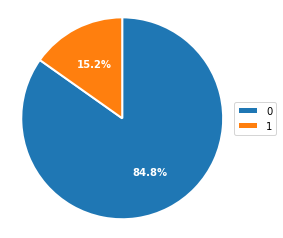


▼ 件数（10年後心疾患である=1，10年後心疾患でない=0）


,TenYearCHD
0,3594
1,644



▼ 10年後の心疾患率
baseline= 0.1519584709768759


In [3]:
print('\n▼ 目的変数TenYearCHDの種類（%）※10年後心疾患である=1，10年後心疾患でない=0')
per_class = round(df['TenYearCHD'].value_counts() / len(df['TenYearCHD']) * 100,2)
values = list(per_class.values)

# 円グラフ
plt.figure(figsize=(4,4))
plt.pie(values, labels=list(per_class.index),
        wedgeprops={'linewidth': 2,'edgecolor':'white'},
        textprops={'color': 'white', 'weight': 'bold'},
        counterclock=False,startangle=90,
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 2.5 else '')
lgnd=plt.legend(bbox_to_anchor=(1.0, 0.25, 1.55, 0.5), loc="center left", borderaxespad=0.)
plt.axis('equal')
plt.show()

print('\n▼ 件数（10年後心疾患である=1，10年後心疾患でない=0）')
display(pd.DataFrame(df['TenYearCHD'].value_counts(),columns=['TenYearCHD']))

print('\n▼ 10年後の心疾患率')
baseline = df['TenYearCHD'].mean()
print('baseline=',baseline)

### 2-2.説明変数の前処理

### 2-2-1.欠損値の補完

In [4]:
print('\n▼ 欠損データ確認')
display(pd.DataFrame(df.isnull().sum()[df.isnull().sum()>0],columns=['Missing num']))

# 最頻値で保管
df['education'] = df['education'].fillna(df['education'].median())
df['cigsPerDay'] = df['cigsPerDay'].fillna(df['cigsPerDay'].median())
df['BPMeds'] = df['BPMeds'].fillna(df['BPMeds'].median())
df['totChol'] = df['totChol'].fillna(df['totChol'].median())
df['BMI'] = df['BMI'].fillna(df['BMI'].median())
df['heartRate'] = df['heartRate'].fillna(df['heartRate'].median())
df['glucose'] = df['glucose'].fillna(df['glucose'].median())

print('\n▼ 欠損データ確認')
display(pd.DataFrame(df.isnull().sum()[df.isnull().sum()>0],columns=['Missing num']))



▼ 欠損データ確認


,Missing num
education,105
cigsPerDay,29
BPMeds,53
totChol,50
BMI,19
heartRate,1
glucose,388



▼ 欠損データ確認


,Missing num


In [5]:
print('\n ▼ カラムの型リスト表示 ')

col_list = df.columns.tolist() 
display(df[col_list].dtypes.sort_values()) 

# int64リスト
i_cols = df[col_list].dtypes[df[col_list].dtypes=='int64'].index.tolist()

# float64リスト
f_cols = df[col_list].dtypes[df[col_list].dtypes=='float64'].index.tolist()

# ヒストグラムで確認する項目
col_chk_hist = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

# カウントプロットで確認する項目
col_chk_cnt = ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']


 ▼ カラムの型リスト表示 


male                 int64
age                  int64
currentSmoker        int64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
TenYearCHD           int64
education          float64
cigsPerDay         float64
BPMeds             float64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
dtype: object

### 2-2-2. 目的変数と説明変数の関係


▼ 相関係数をヒートマップにして可視化


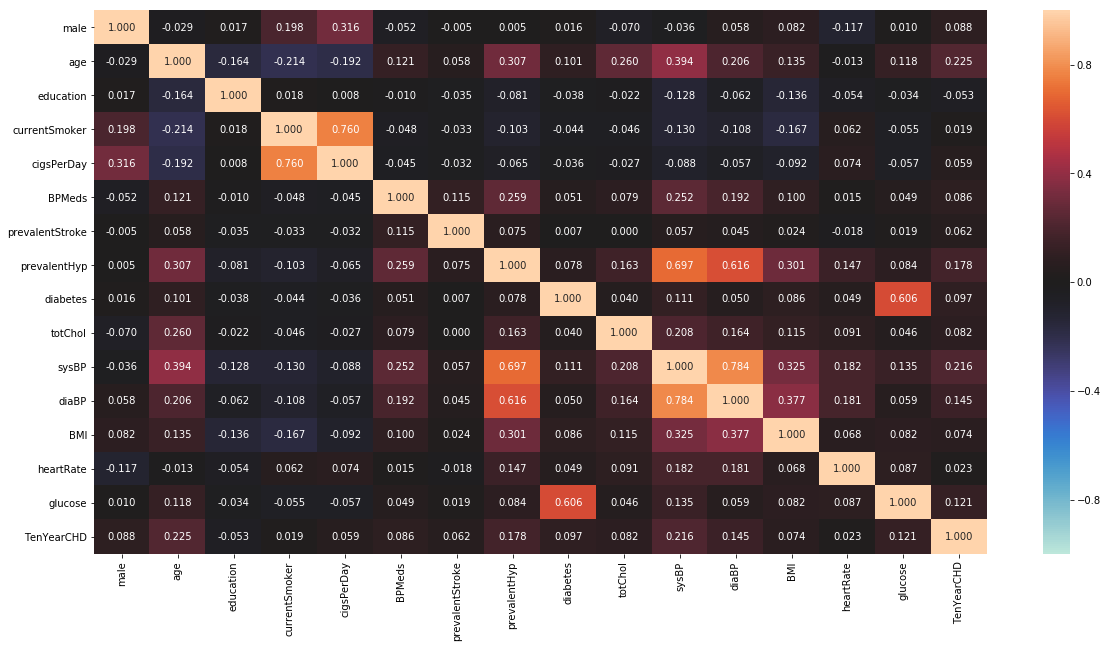

In [6]:
# 散布図行列
#plt.figure(figsize=(10,6))
#sns.pairplot(df, hue="TenYearCHD")
#plt.show()

# ヒートマップ
corrmat = df.corr()
print('\n▼ 相関係数をヒートマップにして可視化')
plt.figure(figsize=(20,10))
sns.heatmap(corrmat, annot=True, fmt='1.3f',vmax=1, vmin=-1, center=0)
plt.show()

▼TenYearCHDと相関が強い項目
['TenYearCHD', 'age', 'sysBP', 'prevalentHyp', 'diaBP', 'glucose', 'diabetes', 'male', 'BPMeds', 'totChol']


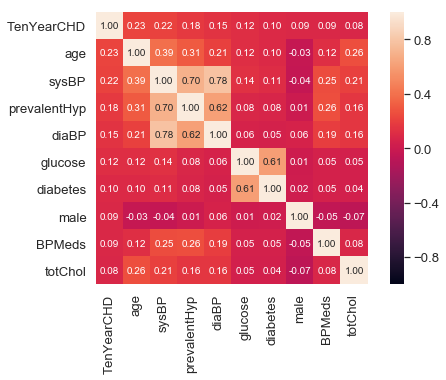

In [7]:
# TenYearCHDと相関させるために最も重要なトップ10をプロット
k = 10
cols = corrmat.nlargest(k, 'TenYearCHD')['TenYearCHD'].index
print('▼TenYearCHDと相関が強い項目\n' + str(cols.tolist()))
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.2)
f, ax = plt.subplots(figsize=(8, 5))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, vmax=1, vmin=-1, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


 ──────────────────────────────────────── 


<Figure size 432x288 with 0 Axes>

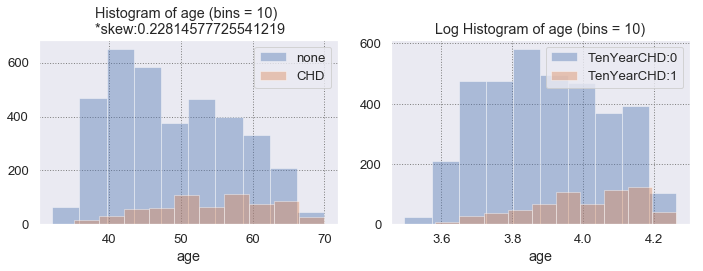


 ──────────────────────────────────────── 


<Figure size 432x288 with 0 Axes>

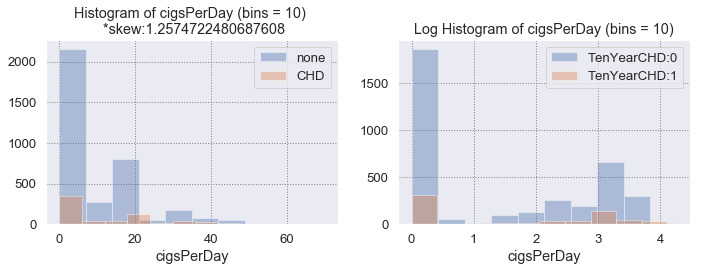


 ──────────────────────────────────────── 


<Figure size 432x288 with 0 Axes>

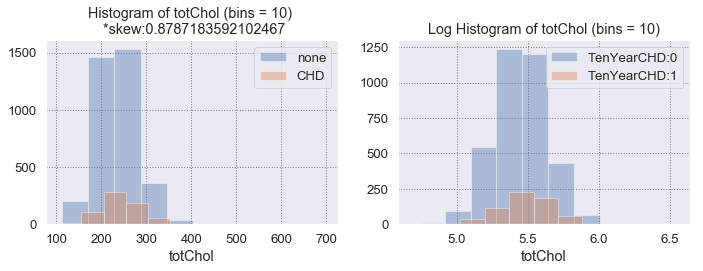


 ──────────────────────────────────────── 


<Figure size 432x288 with 0 Axes>

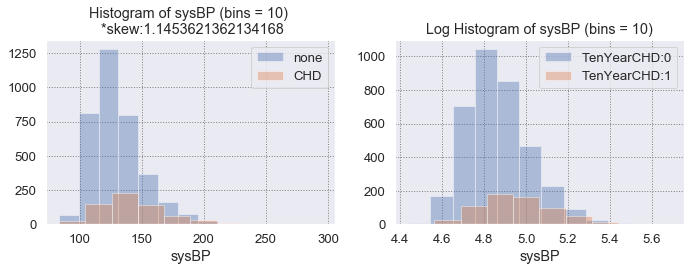


 ──────────────────────────────────────── 


<Figure size 432x288 with 0 Axes>

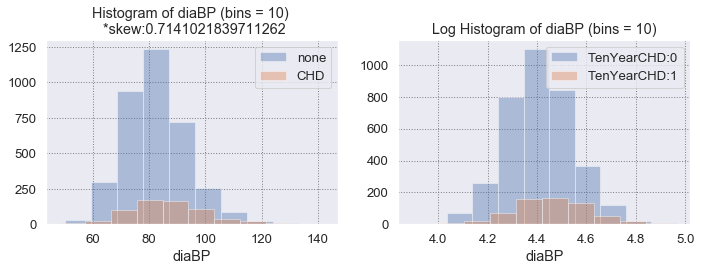


 ──────────────────────────────────────── 


<Figure size 432x288 with 0 Axes>

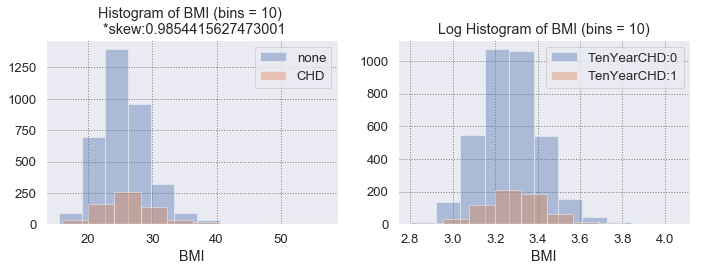


 ──────────────────────────────────────── 


<Figure size 432x288 with 0 Axes>

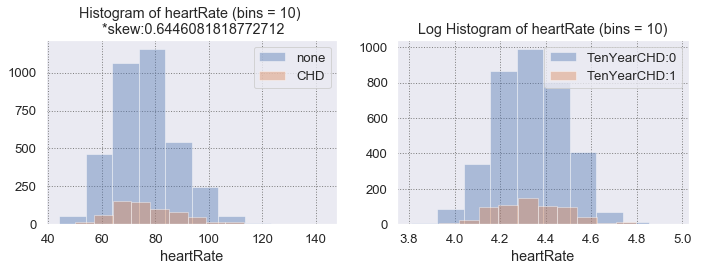


 ──────────────────────────────────────── 


<Figure size 432x288 with 0 Axes>

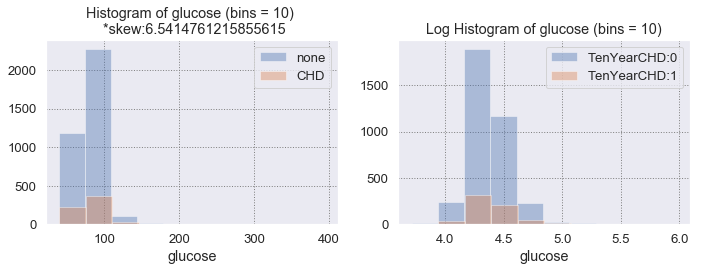

In [8]:
# ------------------------------------------------
# 2-3-3.カテゴリ項目の確認
# ------------------------------------------------    
bins_val = 10
for col_name in col_chk_hist:
    print('\n ──────────────────────────────────────── ')
    plt.subplots_adjust(wspace=2.0, hspace=2.0) # 余白
    plt.figure(figsize=(10,4))
    
    # ヒストグラム
    plt.subplot(1,2,1)
    sns.distplot(df[df['TenYearCHD']==0][col_name],kde=False,rug=False,bins=bins_val,label='none')
    sns.distplot(df[df['TenYearCHD']==1][col_name],kde=False,rug=False,bins=bins_val,label='CHD')
    plt.title('Histogram of ' + str(col_name) + ' (bins = ' + str(bins_val) + ') \n *skew:' + str(df[col_name].skew()))
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.legend()
    
    # 対数ヒストグラム
    plt.subplot(1,2,2)
    sns.distplot(np.log1p(df[df['TenYearCHD']==0][col_name]),kde=False,rug=False,bins=bins_val,label='TenYearCHD:0')
    sns.distplot(np.log1p(df[df['TenYearCHD']==1][col_name]),kde=False,rug=False,bins=bins_val,label='TenYearCHD:1')
    plt.title('Log Histogram of ' + str(col_name) + ' (bins = ' + str(bins_val) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.xlabel(col_name)
    plt.legend()
    plt.tight_layout() # 重ならないように
    plt.show()



 ──────────────────────────────────────────────────── 


<Figure size 432x288 with 0 Axes>

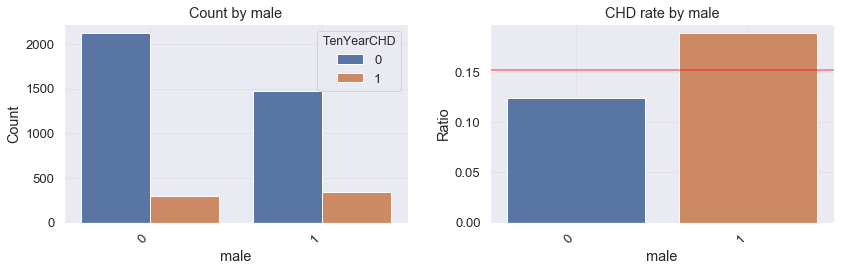


 ──────────────────────────────────────────────────── 


<Figure size 432x288 with 0 Axes>

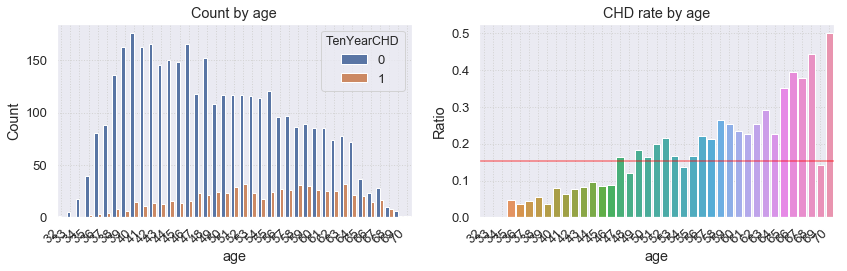


 ──────────────────────────────────────────────────── 


<Figure size 432x288 with 0 Axes>

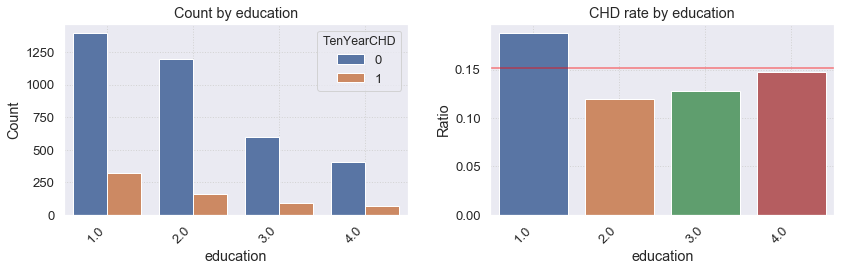


 ──────────────────────────────────────────────────── 


<Figure size 432x288 with 0 Axes>

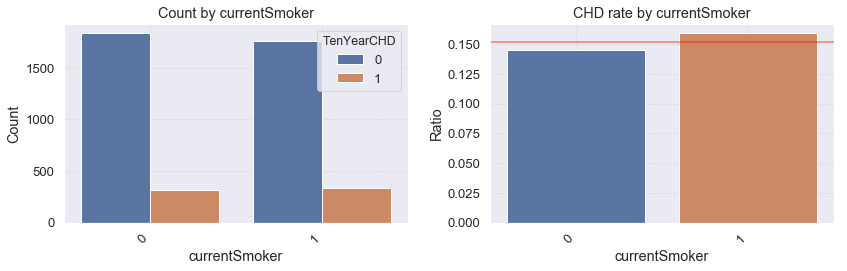


 ──────────────────────────────────────────────────── 


<Figure size 432x288 with 0 Axes>

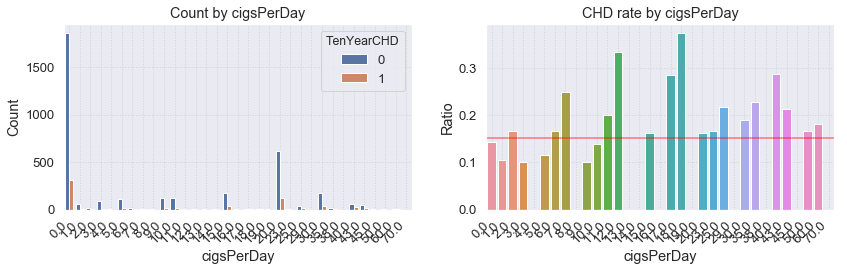


 ──────────────────────────────────────────────────── 


<Figure size 432x288 with 0 Axes>

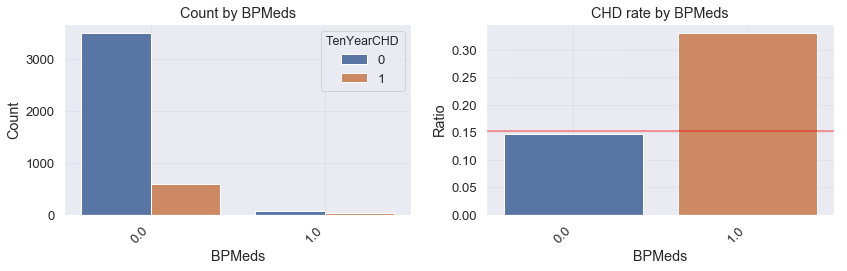


 ──────────────────────────────────────────────────── 


<Figure size 432x288 with 0 Axes>

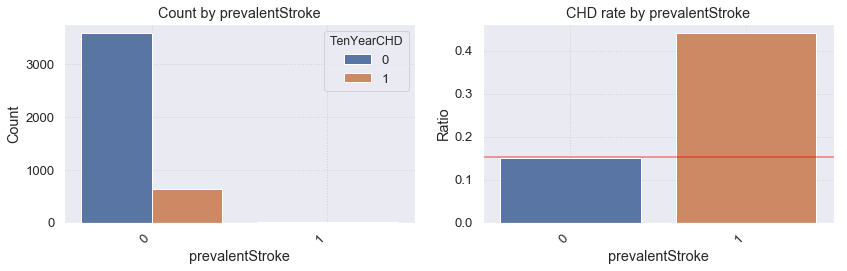


 ──────────────────────────────────────────────────── 


<Figure size 432x288 with 0 Axes>

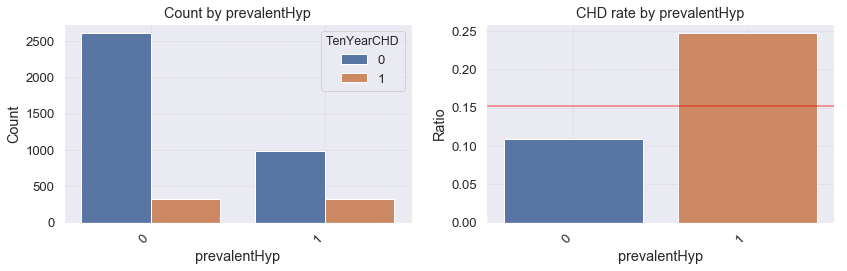


 ──────────────────────────────────────────────────── 


<Figure size 432x288 with 0 Axes>

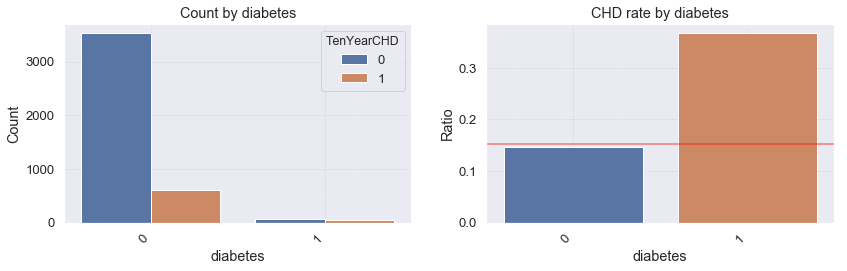

In [9]:
# ------------------------------------------------
# 2-3-3.カテゴリ項目の確認
# ------------------------------------------------    
for col_name in col_chk_cnt:
    print('\n ──────────────────────────────────────────────────── ')
    plt.subplots_adjust(wspace=2.0, hspace=2.0) # 余白
    plt.figure(figsize=(12,4))
    
    # カウントプロット
    plt.subplot(1,2,1)
    ax = sns.countplot(df[col_name],hue=df['TenYearCHD'])
    ax.set_title('Count by ' + str(col_name))
    plt.grid(which='major',color='lightgray',linestyle=':')
    plt.grid(which='minor',color='lightgray',linestyle=':')
    ax.set_xlabel(col_name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right") # ラベルの回転
    ax.set_ylabel('Count')
    
    # 心疾患率プロット
    plt.subplot(1,2,2)
    eat_rate = pd.DataFrame(df['TenYearCHD'].groupby(df[col_name]).mean())
    eat_rate.reset_index(inplace = True) # index振り直し
    ax = sns.barplot(x=col_name, y="TenYearCHD", data=eat_rate)
    ax.axhline(baseline, alpha=0.5, color='red') # 平均値
    ax.set_title('CHD rate by ' + str(col_name))
    plt.grid(which='major',color='lightgray',linestyle=':')
    plt.grid(which='minor',color='lightgray',linestyle=':')
    ax.set_xlabel(col_name)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right") # ラベルの回転
    ax.set_ylabel('Ratio')
    plt.tight_layout() # 重ならないように
    plt.show()

### 2-2-3. 無相関化



**▼ sysBP と diaBP の相関 ※相関係数: 0.784**

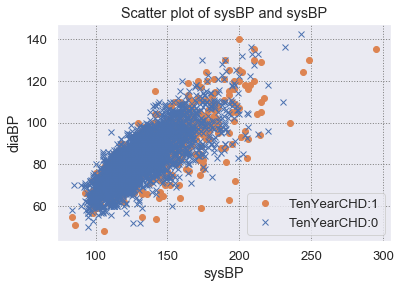

→無相関化してみる




**▼ sysBP と diaBP の相関 ※相関係数: -0.000**

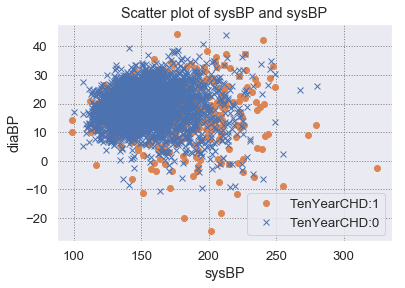

In [10]:
# 相関関係の散布図
show_corr_scatter_plot('sysBP','diaBP',6,4)

# 無相関化する場合
print('→無相関化してみる')
cov_data = df[['sysBP','diaBP']].values
cov = np.cov(cov_data, rowvar=0)            # 分散・共分散を求める
_, S = np.linalg.eig(cov)                   # 分散共分散行列の固有ベクトルを用いて
cov_data_decorr = np.dot(S.T, cov_data.T).T # データを無相関化

df['sysBP'] = cov_data_decorr[:,0]
df['diaBP'] = cov_data_decorr[:,1]

# 無相関化後の散布図
show_corr_scatter_plot('sysBP','diaBP',6,4)

### 2-2-4. カテゴリ変換と標準化

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,125.672533,18.504447,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,143.919971,22.114295,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,149.384292,18.454898,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,176.120012,22.510913,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,153.343385,21.019188,23.10,85.0,85.0,0




**▼ データ分割後行列**

X_train_df= (2966, 15)
y_train_df= (2966,)
X_test_df= (1272, 15)
y_test_df= (1272,)




**▼ カテゴリ変換後行列**

enc_X_train_df= (2966, 21)
enc_X_test_df= (1272, 21)




**▼ カテゴリ変換後**

,male_1.0,male_0.0,age,education,currentSmoker_1.0,currentSmoker_0.0,cigsPerDay,BPMeds_0.0,BPMeds_1.0,prevalentStroke_0.0,...,prevalentHyp_0.0,prevalentHyp_1.0,diabetes_0.0,diabetes_1.0,totChol,sysBP,diaBP,BMI,heartRate,glucose
2691,1,0,58,2.0,1,0,20.0,1,0,1,...,1,0,1,0,207.0,133.532130,25.868328,23.55,78.0,78.0
3799,1,0,54,3.0,1,0,30.0,1,0,1,...,0,1,1,0,267.0,166.725892,22.488371,25.36,92.0,87.0
283,0,1,39,4.0,0,1,0.0,1,0,1,...,1,0,1,0,260.0,122.143816,25.122465,20.51,96.0,66.0
2661,0,1,65,3.0,0,1,0.0,1,0,1,...,1,0,1,0,344.0,140.472385,17.102893,25.41,87.0,98.0
1845,1,0,57,1.0,0,1,0.0,1,0,1,...,0,1,1,0,263.0,172.073036,23.299574,29.08,63.0,78.0




**▼ndarray変換**

X_train.shape= (2966, 21)




**▼標準化対象列**

{'age': 2, 'education': 3, 'cigsPerDay': 6, 'totChol': 15, 'sysBP': 16, 'diaBP': 17, 'BMI': 18, 'heartRate': 19, 'glucose': 20}




**▼標準化**

<Figure size 432x288 with 0 Axes>

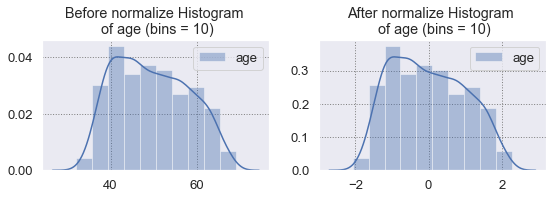

<Figure size 432x288 with 0 Axes>

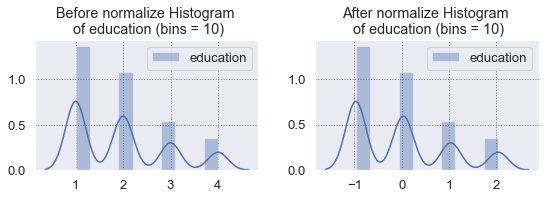

<Figure size 432x288 with 0 Axes>

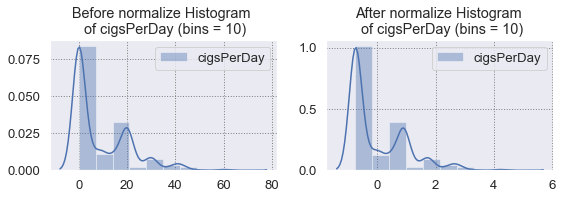

<Figure size 432x288 with 0 Axes>

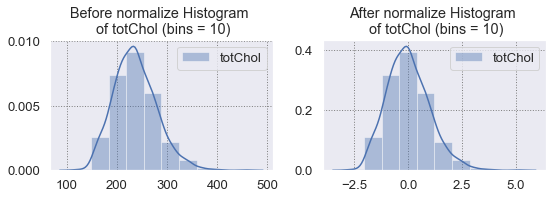

<Figure size 432x288 with 0 Axes>

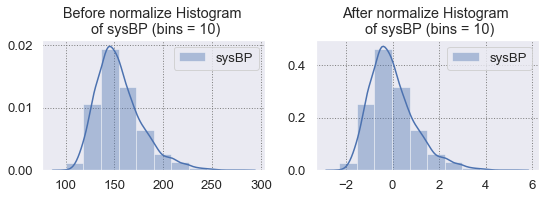

<Figure size 432x288 with 0 Axes>

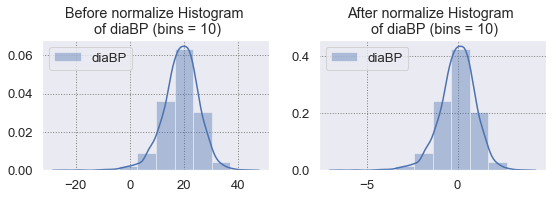

<Figure size 432x288 with 0 Axes>

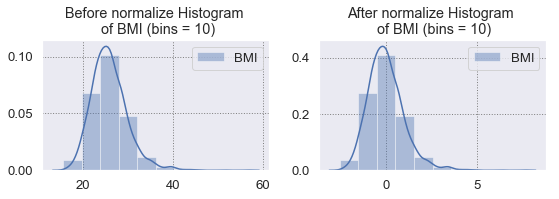

<Figure size 432x288 with 0 Axes>

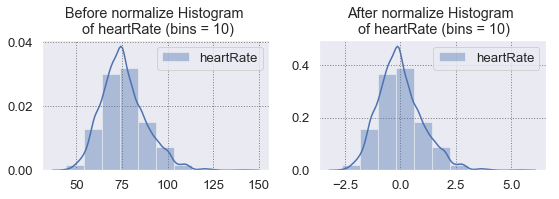

<Figure size 432x288 with 0 Axes>

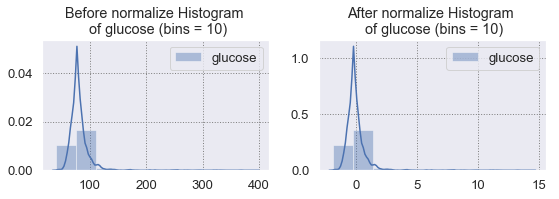

In [11]:
display(df.head(5))

# 標準化＆白色化する項目リスト
enc_norm_col = ['age','education','cigsPerDay','totChol','sysBP','diaBP','BMI','heartRate','glucose']
list_one_hot_cols = ['male','currentSmoker','BPMeds','prevalentStroke','prevalentHyp','diabetes']

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(df.drop('TenYearCHD', axis=1), df['TenYearCHD'],
                                                                test_size=0.3, random_state=1234)

printmd('▼ データ分割後行列')
print('X_train_df=',X_train_df.shape)
print('y_train_df=',y_train_df.shape)
print('X_test_df=',X_test_df.shape)
print('y_test_df=',y_test_df.shape)

# one-hot-encoding
ce_ohe = ce.OneHotEncoder(cols=list_one_hot_cols, use_cat_names=True)
enc_X_train_df = ce_ohe.fit_transform(X_train_df)
enc_X_test_df = ce_ohe.transform(X_test_df)

printmd('▼ カテゴリ変換後行列')
print('enc_X_train_df=',enc_X_train_df.shape)
print('enc_X_test_df=',enc_X_test_df.shape)

printmd('▼ カテゴリ変換後')
display(enc_X_train_df.head(5))

# 標準化する列名と列番号の辞書
dic_norm_col = {}
for col_name in enc_norm_col:
    dic_norm_col.setdefault(col_name, enc_X_train_df.columns.get_loc(col_name))
X_columns = enc_X_train_df.columns
    
# ndarrayに変換
X_train = enc_X_train_df.values
y_train = y_train_df.values
X_test = enc_X_test_df.values
y_test = y_test_df.values

printmd('▼ndarray変換')
print('X_train.shape=',X_train.shape)

printmd('▼標準化対象列')
print(dic_norm_col)

printmd('▼標準化')
for col_name,col_idx in dic_norm_col.items():
    
    plt.subplots_adjust(wspace=8.0, hspace=2.0) # 余白
    plt.figure(figsize=(8,3))
    
    # 標準化前
    plt.subplot(1,2,1)
    sns.distplot(X_train[:,col_idx:col_idx+1],kde=True,rug=False,bins=10,label=col_name)
    plt.title('Before normalize Histogram \n of ' + str(col_name) + ' (bins = ' + str(10) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.legend()
    
    # 標準化
    stdsc = StandardScaler()
    X_train[:,col_idx:col_idx+1] = stdsc.fit_transform(X_train[:,col_idx:col_idx+1])
    X_test[:,col_idx:col_idx+1] = stdsc.transform(X_test[:,col_idx:col_idx+1])
    
    #　標準化後
    plt.subplot(1,2,2)
    sns.distplot(X_train[:,col_idx:col_idx+1],kde=True,rug=False,bins=10,label=col_name)
    plt.title('After normalize Histogram \n of ' + str(col_name) + ' (bins = ' + str(10) + ')')
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.legend()
    plt.tight_layout() # 重ならないように
    plt.show()

## 3.モデル構築

Score: 0.830748 (0.014160) with: {'alpha': 0.0001, 'penalty': 'none'}
----------------------------------------------
Score: 0.837492 (0.009777) with: {'alpha': 0.0001, 'penalty': 'l1'}
----------------------------------------------
Score: 0.831086 (0.014311) with: {'alpha': 0.0001, 'penalty': 'l2'}
----------------------------------------------
Score: 0.836480 (0.008440) with: {'alpha': 0.0001, 'penalty': 'elasticnet'}
----------------------------------------------
Score: 0.855361 (0.006238) with: {'alpha': 0.001, 'penalty': 'none'}
----------------------------------------------
Score: 0.851989 (0.006227) with: {'alpha': 0.001, 'penalty': 'l1'}
----------------------------------------------
Score: 0.855698 (0.004146) with: {'alpha': 0.001, 'penalty': 'l2'}
----------------------------------------------
Score: 0.852664 (0.004144) with: {'alpha': 0.001, 'penalty': 'elasticnet'}
----------------------------------------------
Score: 0.853001 (0.008812) with: {'alpha': 0.01, 'penalty': 'non

,feature,weight
0,male_1.0,0.524372
1,age,0.515047
2,prevalentStroke_1.0,0.423656
3,sysBP,0.353892
4,currentSmoker_1.0,0.294213
5,prevalentHyp_1.0,0.285382
6,diabetes_1.0,0.280508
7,BPMeds_0.0,0.232507
8,BPMeds_1.0,0.199488
9,cigsPerDay,0.171933



▼ 重みの大きさを横棒グラフで表示


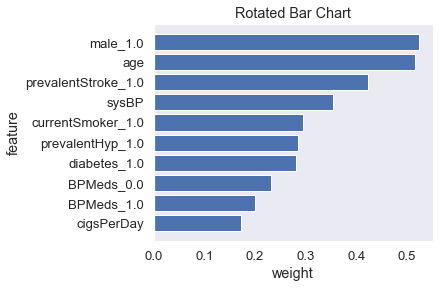

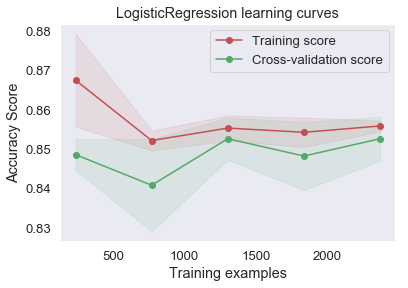

In [12]:
# ロジスティック回帰モデル生成
kfold = KFold(n_splits=5, random_state=1234)
lr_clf = SGDClassifier(loss='log',max_iter=10000,fit_intercept=True,random_state=1234,tol=1e-3)
lr_param_grid = {'penalty' : ['none','l1','l2','elasticnet'],#正則化項（default = 'l2'）
                 'alpha' : [1e-4, 1e-3, 1e-2] # 正則化項の効き具合(default = 0.0001:1e-4)
                }
grid = GridSearchCV(estimator=lr_clf, param_grid=lr_param_grid, scoring='accuracy', cv=kfold, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
best_lr = grid_result.best_estimator_

# 結果
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Score: %f (%f) with: %r" % (mean, stdev, param))
    print("----------------------------------------------")
print("★BestScore: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# 学習
best_lr.fit(X_train, y_train)

#print('w0 = {:.3f}'.format(clf.intercept_[0]))

# 結果をDataFrameへ格納
res_df = pd.DataFrame(columns=['feature','weight','abs_w'])
res_df['feature'] = list(X_columns)
res_df['weight'] = np.reshape(best_lr.coef_[0], -1).tolist() # 重み
res_df['abs_w'] = abs(res_df['weight']) # 絶対値

# 重みの絶対値の降順ソート
print('\n▼ 重みを表示（絶対値の降順：Top10）')
res_df = res_df.sort_values('abs_w', ascending=False)
res_df.reset_index(drop=True,inplace=True)
res_df = res_df.drop('abs_w', axis=1)
res_df_head = res_df.head(10)
display(res_df_head.head(10))

# 重みの大きさを横棒グラフで表示
print('\n▼ 重みの大きさを横棒グラフで表示')
plt.figure(figsize=(5, 4))
plt.barh(np.arange(len(res_df_head['feature']))[::-1], res_df_head['weight'], align='center')
plt.yticks(np.arange(len(res_df_head['feature']))[::-1], res_df_head['feature'])
plt.title('Rotated Bar Chart')
plt.xlabel('weight')
plt.ylabel('feature')
plt.grid()
plt.show()

# ロジスティック回帰の学習曲線
plot_learning_curve(best_lr,"LogisticRegression learning curves",X_train,y_train,cv=kfold)

## 4.モデル評価

In [13]:
# テストデータ予測
y_test_pred = best_lr.predict(X_test)

printmd('▼ モデルの評価結果')
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_test_pred)))
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_test_pred)))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred)
print('適合率（Precision※精度) = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall※検出率) = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

# 予測値と正解のクロス集計
printmd('▼ 混同行列')
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
                        index=['正解 = 10年後CHDでない', '正解 =10年後CHDである'], 
                     columns=['予測 = 10年後CHDでない', '予測 = 10年後CHDである'])

display(conf_mat)



**▼ モデルの評価結果**

対数尤度 = -5.295
正答率 = 84.670%
適合率（Precision※精度) = 84.909%
再現率（Recall※検出率) = 99.534%
F1値（F1-score） = 91.642%




**▼ 混同行列**

,予測 = 10年後CHDでない,予測 = 10年後CHDである
正解 = 10年後CHDでない,1069,5
正解 =10年後CHDである,190,8


## 5. 決定木モデル



**▼ 決定木モデルの評価結果**

正答率 = 84.119%


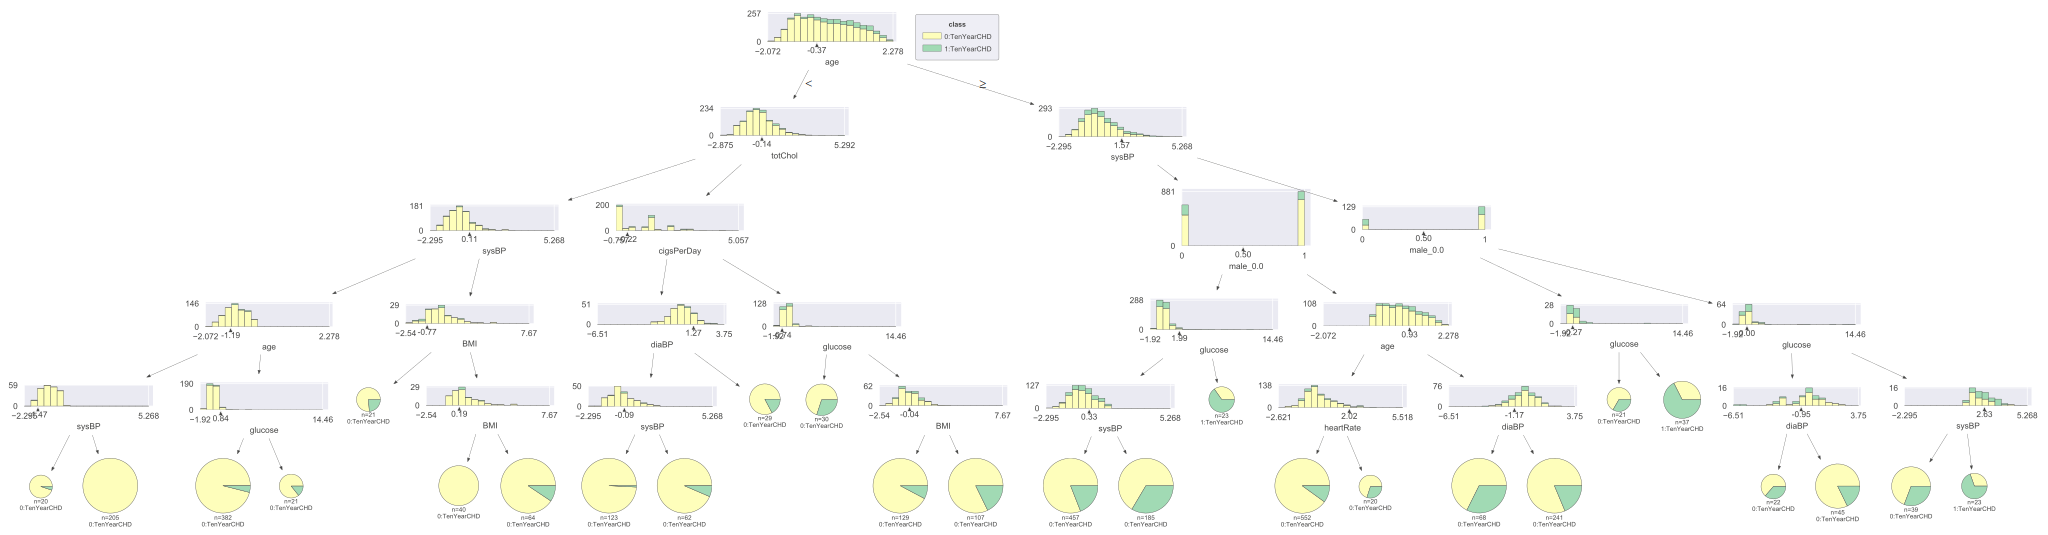

In [14]:
# 決定木モデル生成
dt = DecisionTreeClassifier(max_depth=5, min_samples_split=15, min_samples_leaf=20, random_state=1234)
dt.fit(X_train, y_train)
y_est_dt = dt.predict(X_test)

printmd('▼ 決定木モデルの評価結果')
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est_dt)))

from sklearn.datasets import *
from sklearn import tree
from dtreeviz.trees import *
import graphviz

viz = dtreeviz(dt,X_train=X_train,
               y_train=y_train,
               target_name='class',
               class_names=['0:TenYearCHD','1:TenYearCHD'],
               ticks_fontsize=12.0,
               feature_names=enc_X_train_df.columns)
              
display(viz)